In [262]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
torch.set_grad_enabled(False) 
torch.set_printoptions(precision=4,sci_mode=False)

# Config

In [263]:
import torch
from utils import increment_path
from pathlib import Path
import shutil
import os

project = "paper experiment"
name = "SFMCNN"
group = "4/24"
tags = ["SFMCNN", "Rewrite"]
description = "4/22 對照組 無max-min normalize的 w 方案一效果"
device = 'cpu'

# save_dir = increment_path('./runs/train/exp', exist_ok = False)
# Path(save_dir).mkdir(parents=True, exist_ok=True)
# print(save_dir)

lr_scheduler = {
    "name": "ReduceLROnPlateau",
    "args":{
        "patience": 100
    }
}

optimizer = {
    "name":"Adam",
    "args":{

    }
}

arch = {
    "name": 'SFMCNN',
    "args":{
        "in_channels": 1,
        "out_channels": 10,
        "Conv2d_kernel": [(5, 5), (1, 1), (1, 1), (1, 1)],
        "SFM_filters": [(2, 2), (1, 3), (3, 1)],
        "channels": [1, 100, 225, 625, 1225],
        "strides": [4, 1, 1, 1],
        "paddings": [0, 0, 0, 0],
        "w_arr": [7.45, 12.45, 17.45, 27.45],
        "percent": [0.5, 0.4, 0.3, 0.2],
        "fc_input": 1225,
        "device": device
    }
}

# arch = {
#     "name": 'SFMCNN_old',
#     "args":{
#         "in_channels": 1,
#         "out_channels": 10,
#         "Conv2d_kernel": [(5, 5), (1, 1), (1, 1), (1, 1)],
#         "SFM_filters": [(2, 2), (1, 3), (3, 1)],
#         "channels": [1, 100, 225, 625, 1225],
#         "strides": [4, 1, 1, 1],
#         "paddings": [0, 0, 0, 0],
#         "w_arr": [7.45, 12.45, 17.45, 27.45],
#         "percent": [0.5, 0.4, 0.3, 0.2],
#         "fc_input": 1225,
#         "device": device
#     }
# }

# arch = {
#     "name": 'AlexNet',
#     "args":{
#         "num_classes":15
#     }
# }

config = {
    "device": device,
    "root": 'os.path.dirname(__file__)',
    "save_dir": 'save_dir',
    "model": arch,
    "dataset": 'mnist', # mnist、fashion、cifar10、MultiColor_Shapes_Database、malaria、face_dataset
    "input_shape": (28, 28),
    "rbf": "triangle",
    "batch_size": 256,
    "epoch" : 200,
    "lr" : 0.001,
    "lr_scheduler": lr_scheduler,
    "optimizer": optimizer,
    "loss_fn": "CrossEntropyLoss",
}

In [264]:
device = 'cpu'
config['device'] = device
arch['device'] = device

# SFMCNN

In [265]:
from torch.nn.modules.utils import _pair
from torch.nn.common_types import _size_2_t
from torch.nn import init
from torch import nn
from torch import Tensor

import torch.nn.functional as F
import torch
import math

class SFMCNN(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 Conv2d_kernel, 
                 channels, 
                 SFM_filters, 
                 strides, 
                 paddings,
                 w_arr,
                 percent,
                 fc_input,
                 device) -> None:
        super().__init__()

        
        # TODO 檢查是否各個block的initial function
        self.convs = nn.Sequential(
                *[self._make_BasicBlock(channels[i], 
                                        channels[i+1], 
                                        Conv2d_kernel[i], 
                                        stride = strides[i],
                                        padding = paddings[i], 
                                        filter = SFM_filters[i], 
                                        percent=percent[i],
                                        w = w_arr[i], 
                                        initial="kaiming",
                                        device = device) for i in range(len(SFM_filters))],
                self._make_ConvBlock(channels[-2], 
                                     channels[-1], 
                                     Conv2d_kernel[-1], 
                                     stride = strides[-1],
                                     padding = paddings[-1], 
                                     percent=percent[-1], 
                                     w=w_arr[-1], 
                                     device = device)
            )


        self.fc1 = nn.Sequential(
            nn.Linear(fc_input, out_channels)
        )

    def forward(self, x):
        output = self.convs(x)
        output = self.fc1(output.reshape(x.shape[0], -1))
        return output

    def _make_BasicBlock(self,
                    in_channels:int, 
                    out_channels:int, 
                    kernel_size:tuple,
                    stride:int = 1,
                    padding:int = 0,
                    filter:tuple = (1,1),
                    w:float = 0.4,
                    percent: float = 0.5,
                    initial: str = "kaiming",
                    device:str = "cuda"):
        return nn.Sequential(
            RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, initial = initial,device = device),
            triangle_cReLU(w=w, percent=percent, requires_grad = True, device=device),
            SFM(filter = filter, device = device)
        )

    def _make_ConvBlock(self,
                    in_channels, 
                    out_channels, 
                    kernel_size,
                    stride:int = 1,
                    padding:int = 0,
                    w = 4.0,
                    percent = 0.4,
                    device:str = "cuda"):
        return nn.Sequential(
            RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, device = device),
            triangle_cReLU(w=w, percent=percent, requires_grad = True, device=device),
        )


'''
    RBF 卷積層
    return output shape = (batches, channels, height, width)
'''
class RBF_Conv2d(nn.Module):
    def __init__(self,
                 in_channels:int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int = 1,
                 padding: int = 0,
                 initial:str = "kaiming",
                 device=None,
                 dtype=None):
        super().__init__()
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = padding
        factory_kwargs = {'device':device, 'dtype':dtype}
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.initial = initial

        self.weight = torch.empty((out_channels, in_channels * self.kernel_size[0] * self.kernel_size[1]), **factory_kwargs)
        self.reset_parameters(initial)
    
    def reset_parameters(self, initial) -> None:
        if initial == "kaiming":
            # kaiming 初始化
            # bound  = sqrt(6/(1 + a^2 * fan))
            # fan = self.weight.size(1) * 1
            init.kaiming_uniform_(self.weight)
        elif initial == "uniform":
            init.uniform_(self.weight)
        else:
            raise "RBF_Conv2d initial error"

        self.weight = nn.Parameter(self.weight)
    
    def forward(self, input: Tensor) -> Tensor:
        # print(f"RBF weights = {self.weight[0]}")
        output_width = math.floor((input.shape[-1] + self.padding * 2 - (self.kernel_size[0] - 1) - 1) / self.stride[0] + 1)
        output_height = math.floor((input.shape[-2] + self.padding * 2 - (self.kernel_size[1] - 1) - 1) / self.stride[1] + 1)
        windows = F.unfold(input, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding).permute(0, 2, 1)

        # TODO weight取平方
        # # 將weight取平方保證其範圍落在 0 ~ 1 之間
        # weights = torch.pow(self.weight, 2)

        #1. 取絕對值距離
        # weight_expand = self.weight.unsqueeze(1).unsqueeze(2)
        # result = (windows - weight_expand).permute(1,0,2,3)
        # result = torch.abs(result).sum(dim=-1)
        
        #2. 取歐基里德距離
        result = torch.cdist(windows, self.weight).permute(0, 2, 1)

        result = result.reshape(result.shape[0], result.shape[1], output_height, output_width)
        return result
    
    def extra_repr(self) -> str:
        return f"initial = {self.initial}, weight shape = {(self.out_channels, self.in_channels, *self.kernel_size)}"

class triangle(nn.Module):
    def __init__(self, 
                 w: float, 
                 requires_grad: bool = False, 
                 device:str = "cuda"):
        super().__init__()
        self.w = torch.Tensor([w]).to(device)
        if requires_grad:
            self.w = nn.Parameter(self.w, requires_grad = True)

    def forward(self, d):
        w_tmp = self.w
        d[d>=w_tmp] = w_tmp
        return torch.ones_like(d) - torch.div(d, w_tmp)
    
    def extra_repr(self) -> str:
        return f"w = {self.w.item()}"

class gauss(nn.Module):
    def __init__(self, std, requires_grad: bool = True, device:str = "cuda"):
        super().__init__()
        self.std = torch.Tensor([std]).to(device)
        if requires_grad:
            self.std = nn.Parameter(self.std)

    def forward(self, d):
        return torch.exp(torch.pow(d, 2) / (-2 * torch.pow(self.std, 2)))
    
    def extra_repr(self) -> str:
        return f"std={self.std.item()}"

class cReLU(nn.Module):
    def __init__(self, 
                 bias: float = 0.7,
                 requires_grad: bool = True,
                 device:str = "cuda") -> None:
        super().__init__()
        self.bias = torch.tensor([bias]).to(device)
        if requires_grad:
            self.bias = nn.Parameter(self.bias, requires_grad = True)
    
    def forward(self, x):
        bias_tmp = self.bias
        result = x * torch.ge(x, bias_tmp.repeat(x.shape[0]).view(-1,1,1,1)).float()
        return result
    
    def extra_repr(self) -> str:
        return f"bias={self.bias.item()}"

class triangle_cReLU(nn.Module):
    def __init__(self, 
                 w: float,
                 percent: float,
                 requires_grad: bool = False, 
                 device:str = "cuda"):
        super().__init__()
        self.w = torch.Tensor([w]).to(device)
        self.percent = torch.tensor([percent]).to(device)
        if requires_grad:
            self.w = nn.Parameter(self.w, requires_grad = True)

    def forward(self, d):
        # input()
        w_tmp = self.w
        # print(f'd = {d[0]}')

        # 1. 取所有數字的對應percent值當作唯一threshold
        d_flatten = d.reshape(d.shape[0], -1)
        top_k, _ = d_flatten.topk(math.ceil(self.percent * d_flatten.shape[1]), dim=1, largest=False)
        threshold = top_k[:, -1]
        # 將 threshold 中大於 w 的元素設為 w
        threshold[threshold>w_tmp] = w_tmp
        threshold = threshold.view(-1,1,1,1)
        # print(f'threshold = {threshold}')

        # #2. 每個channel獨立計算threshold
        # threshold, _ = d.topk(int(self.percent * d.shape[1]), dim=1, largest=False)
        # threshold = threshold[:, -1, :, :][:, None, :, :]
        # # 將 threshold 中大於 w 的元素設為 w
        # threshold[threshold > w_tmp] = w_tmp
        # # print(f'threshold = {threshold[0]}') 

        # #3. 取beta
        # threshold  = w_tmp * (1 - self.beta)

        # # 4. threshold 取 最大值 * weight
        # topk, _ = d.topk(k = 1, dim=1)
        # threshold = topk * self.percent

        d = torch.where(d > threshold, w_tmp, d).view(*d.shape)
        result = (torch.ones_like(d) - torch.div(d, w_tmp))
        # print(f"triangle_cRelu after: {torch.max(result)} ~ {torch.min(result)}")
        # print('-----')
        return result
    
    def extra_repr(self) -> str:
        return f"w = {self.w.item()}, percent={self.percent.item()}"

'''
    時序合併層
    parameters:
        filter: 合併的範圍
'''
class SFM(nn.Module):
    def __init__(self,
                 filter: _size_2_t,
                 alpha_max: float = 0.99,
                 alpha_min: float = 0.9,
                 device: str = "cuda") -> None:
        super(SFM, self).__init__()
        self.filter = filter
        self.alpha = torch.linspace(start=alpha_min, end=alpha_max, steps = math.prod(self.filter), requires_grad=True).reshape(*self.filter)
        self.device = device

    def forward(self, input: Tensor) -> Tensor:
        alpha_pows = self.alpha.repeat(input.shape[1], 1, 1).to(self.device)

        batch_num, channels, height, width = input.shape
        _, filter_h, filter_w = alpha_pows.shape

        # 使用 unfold 將 input 展開成形狀為 (batch_num, channels, (height-filter_h+step)*(width-filter_w+step), filter_h * filter_w) 的二維張量
        unfolded_input = input.unfold(2, filter_h, filter_h).unfold(3, filter_w, filter_w).reshape(batch_num, channels, -1, filter_h * filter_w)

        # 將 filter 擴展成形狀為 (1, channels, 1, filter_h * filter_w)
        expanded_filter = alpha_pows.reshape(channels, 1, -1)
        expanded_filter = expanded_filter.repeat(batch_num, 1, 1, 1)

        # 對應相乘
        result = unfolded_input * expanded_filter

        # 將 dim=-1 的維度相加取 mean
        output = result.mean(dim=-1).reshape(batch_num, channels, math.floor(height/filter_h), math.floor(width/filter_w))
        return output
    
    def extra_repr(self) -> str:
        return f"filter={self.filter}, alpha={self.alpha.detach().numpy()}"

# Load Dataset

In [266]:
from torchvision.io import read_image, ImageReadMode
from mlxtend.data import loadlocal_mnist
from torchvision import transforms
import numpy as np

images = []
image_paths = []
labels = []

def custom_sort(filename):
    # 从文件名中提取圈圈顏色和數字部分作为排序依据
    parts = filename.split('_')
    return (parts[0], int(parts[1].split('.')[0]))

if config['dataset'] == 'face_dataset':
    image_folder = r'./data/face_dataset/Train'
    for root, dirs, files in os.walk(image_folder):
        print(files)
        for i, name in enumerate(sorted(files, key=custom_sort)):
            image = read_image(os.path.join(root, name), ImageReadMode.GRAY)
            image = image / 255
            image = transforms.Resize((60,60))(image)
            images.append(image)
            image_paths.append(os.path.join(root, name))
            if name[:4] == 'face':
                labels.append(0)
            else:
                labels.append(1)


    
    images = torch.tensor(np.array(images))
    labels = torch.tensor(np.eye(2)[labels])

elif config['dataset'] == 'mnist':
    images, labels = loadlocal_mnist('./data/MNIST/t10k-images.idx3-ubyte', './data/MNIST/t10k-labels.idx1-ubyte')
    images = images.reshape(-1, 1, 28, 28)
    images = torch.tensor(images/255).float()
    labels = torch.tensor(np.eye(10)[labels])
    


print(images.shape)
print(labels.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


In [267]:
indices = torch.randperm(5000)
images=images[indices]
labels=labels[indices]
print(images.shape)
print(labels.shape)

torch.Size([5000, 1, 28, 28])
torch.Size([5000, 10])


# Load Model

In [268]:
checkpoint = torch.load(f'pth/{config["dataset"]}_pth/0422_SFMCNN_best_fd198ukg.pth')

model = SFMCNN(**dict(config['model']['args']))
model.load_state_dict(checkpoint['model_weights'])
model.cpu()
model.eval()
print(model)

SFMCNN(
  (convs): Sequential(
    (0): Sequential(
      (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
      (1): triangle_cReLU(w = 8.818740844726562, percent=0.5)
      (2): SFM(
        filter=(2, 2), alpha=[[0.9  0.93]
         [0.96 0.99]]
      )
    )
    (1): Sequential(
      (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
      (1): triangle_cReLU(w = 9.15491771697998, percent=0.4000000059604645)
      (2): SFM(filter=(1, 3), alpha=[[0.9   0.945 0.99 ]])
    )
    (2): Sequential(
      (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
      (1): triangle_cReLU(w = 17.383779525756836, percent=0.30000001192092896)
      (2): SFM(
        filter=(3, 1), alpha=[[0.9  ]
         [0.945]
         [0.99 ]]
      )
    )
    (3): Sequential(
      (0): RBF_Conv2d(initial = kaiming, weight shape = (1225, 625, 1, 1))
      (1): triangle_cReLU(w = 17.11222267150879, percent=0.20000000298023224)
    )
  )
  (fc1): Sequential(
  

In [269]:
from torchsummary import summary

summary(model, input_size = (config['model']['args']['in_channels'], *config['input_shape']), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        RBF_Conv2d-1            [-1, 100, 6, 6]           2,500
    triangle_cReLU-2            [-1, 100, 6, 6]               0
               SFM-3            [-1, 100, 3, 3]               0
        RBF_Conv2d-4            [-1, 225, 3, 3]          22,500
    triangle_cReLU-5            [-1, 225, 3, 3]               0
               SFM-6            [-1, 225, 3, 1]               0
        RBF_Conv2d-7            [-1, 625, 3, 1]         140,625
    triangle_cReLU-8            [-1, 625, 3, 1]               0
               SFM-9            [-1, 625, 1, 1]               0
       RBF_Conv2d-10           [-1, 1225, 1, 1]         765,625
   triangle_cReLU-11           [-1, 1225, 1, 1]               0
           Linear-12                   [-1, 10]          12,260
Total params: 943,510
Trainable params: 943,510
Non-trainable params: 0
-------------------------------

In [270]:
batch_num = 1000
pred = model(images[:batch_num])
y = labels[:batch_num]
correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
print(correct/batch_num)

0.806


# Define function

In [271]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def plot_map(rm, grid_size=None, rowspan=None, colspan = None, path=None, **kwargs):
    rows, cols, e_h, e_w, _ = rm.shape
    if rowspan is None:
        rowspan = int(e_h / min(e_h, e_w))
    if colspan is None:
        colspan = int(e_w / min(e_h, e_w))
    if grid_size is None:
        grid_size = (rows*rowspan, cols*colspan)
    fig = plt.figure(figsize=(grid_size[1], grid_size[0]), facecolor="green")
    for row in range(rows):
        for col in range(cols):
            ax = plt.subplot2grid(grid_size, (row*rowspan, col*colspan), rowspan=rowspan, colspan=colspan)
            im = ax.imshow(rm[row][col], **kwargs)
            ax.axis('off')
    
    if path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

In [272]:
def split(input, kernel_size = (5, 5), stride = (5,5)):
    batch, channel, h, w = input.shape
    output_height = math.floor((h  - (kernel_size[0] - 1) - 1) / stride[0] + 1)
    output_width = math.floor((w  - (kernel_size[1] - 1) - 1) / stride[1] + 1)
    input = torch.tensor(input)
    segments = F.unfold(input, kernel_size=kernel_size, stride=stride).reshape(batch, channel, *kernel_size, -1).permute(0,1,4,2,3)
    segments = segments.reshape(batch, channel, output_height, output_width, *kernel_size) 
    return segments

In [273]:
def get_ci(input, layer, kernel_size = (5,5), stride= (5,5), sfm_filter = (1,1)):
    segments = split(input, kernel_size, stride)
    combine_h, combine_w, ci_h, ci_w = (int(segments.shape[2]/sfm_filter[0]), int(segments.shape[3]/sfm_filter[1]), int(segments.shape[4]*sfm_filter[0]), int(segments.shape[5]*sfm_filter[1]))
    segments = segments.reshape(-1, input.shape[1], combine_h, sfm_filter[0], combine_w, sfm_filter[1], segments.shape[4], segments.shape[5])
    segments = segments.permute(0, 2, 4, 3, 6, 5, 7, 1)
    segments = segments.reshape(-1, ci_h, ci_w, input.shape[1])
    print(f"segments shape: {segments.shape}")
    
    with torch.no_grad():
        outputs = layer(input)
        n_filters = outputs.shape[1]
        outputs = outputs.permute(0,2,3,1).reshape(-1, n_filters)
        print(f"output shape: {outputs.shape}")

    k = 1
    CI = torch.empty(n_filters, k, ci_h, ci_w, input.shape[1])
    CI_values = torch.empty(n_filters, k) 
    CI_idx = torch.empty(n_filters, k)    
    for i in range(n_filters):
        values, indices = torch.topk(outputs[:, i], k=k, largest=False)
        CI_idx[i] = indices
        CI_values[i] = values
        CI[i] = segments[indices.tolist()]
    print(f"CI shape: {CI.shape}")
    return CI, CI_idx, CI_values

In [274]:
FMs = {}
CIs = {}
layers = {}

# Layer 0

## FM_0

In [275]:

FMs[0] = model.convs[0][0].weight.reshape(-1, *arch['args']['Conv2d_kernel'][0], 1)
print(f"FMs[0] = {FMs[0].shape}")

FMs[0] = torch.Size([100, 5, 5, 1])


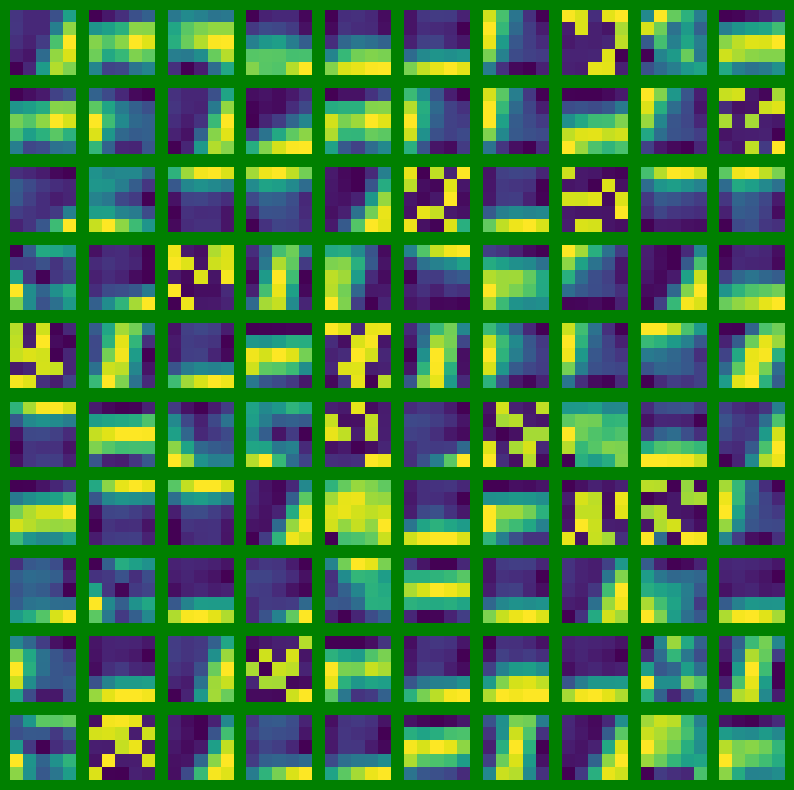

In [276]:
plot_map(FMs[0].reshape(int(FMs[0].shape[0]**0.5), int(FMs[0].shape[0]**0.5), *FMs[0].shape[1:]).detach().numpy())

## CI_0

In [277]:
CIs = {}

layer = nn.Sequential(model.convs[0][:1])
kernel_size = arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 

output = layer(images[0].unsqueeze(0))
output_shape = output.shape[1:]

CI, CI_idx, CI_values = get_ci(images, layer, kernel_size=kernel_size, stride=stride)

CIs[0] = CI
layers[0] = layer

print(f"CIs[0] = {CIs[0].shape}")

C:\Users\user\AppData\Local\Temp\ipykernel_26520\909383208.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


segments shape: torch.Size([180000, 5, 5, 1])
output shape: torch.Size([180000, 100])
CI shape: torch.Size([100, 1, 5, 5, 1])
CIs[0] = torch.Size([100, 1, 5, 5, 1])


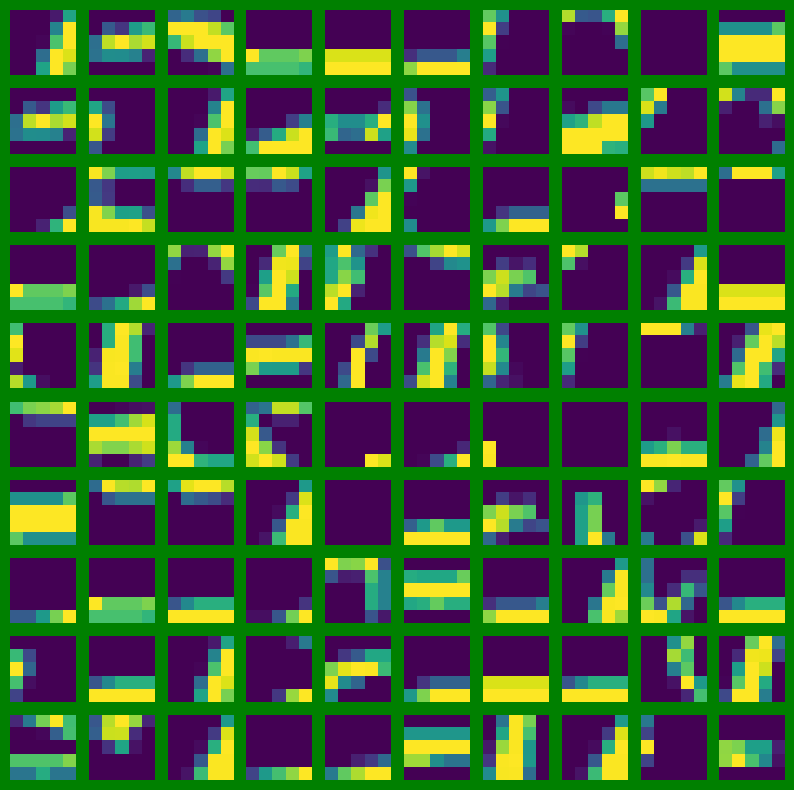

In [278]:
plot_map(CIs[0].reshape(int(CIs[0].shape[0]**0.5), int(CIs[0].shape[0]**0.5),*CIs[0].shape[2:]))

# Layer 1

## FM 1

In [279]:
FMs[1] = model.convs[1][0].weight.reshape(-1, int(model.convs[1][0].weight.shape[1]**0.5), int(model.convs[1][0].weight.shape[1]**0.5), 1)
print(f"FMs[1] = {FMs[1].shape}")

FMs[1] = torch.Size([225, 10, 10, 1])


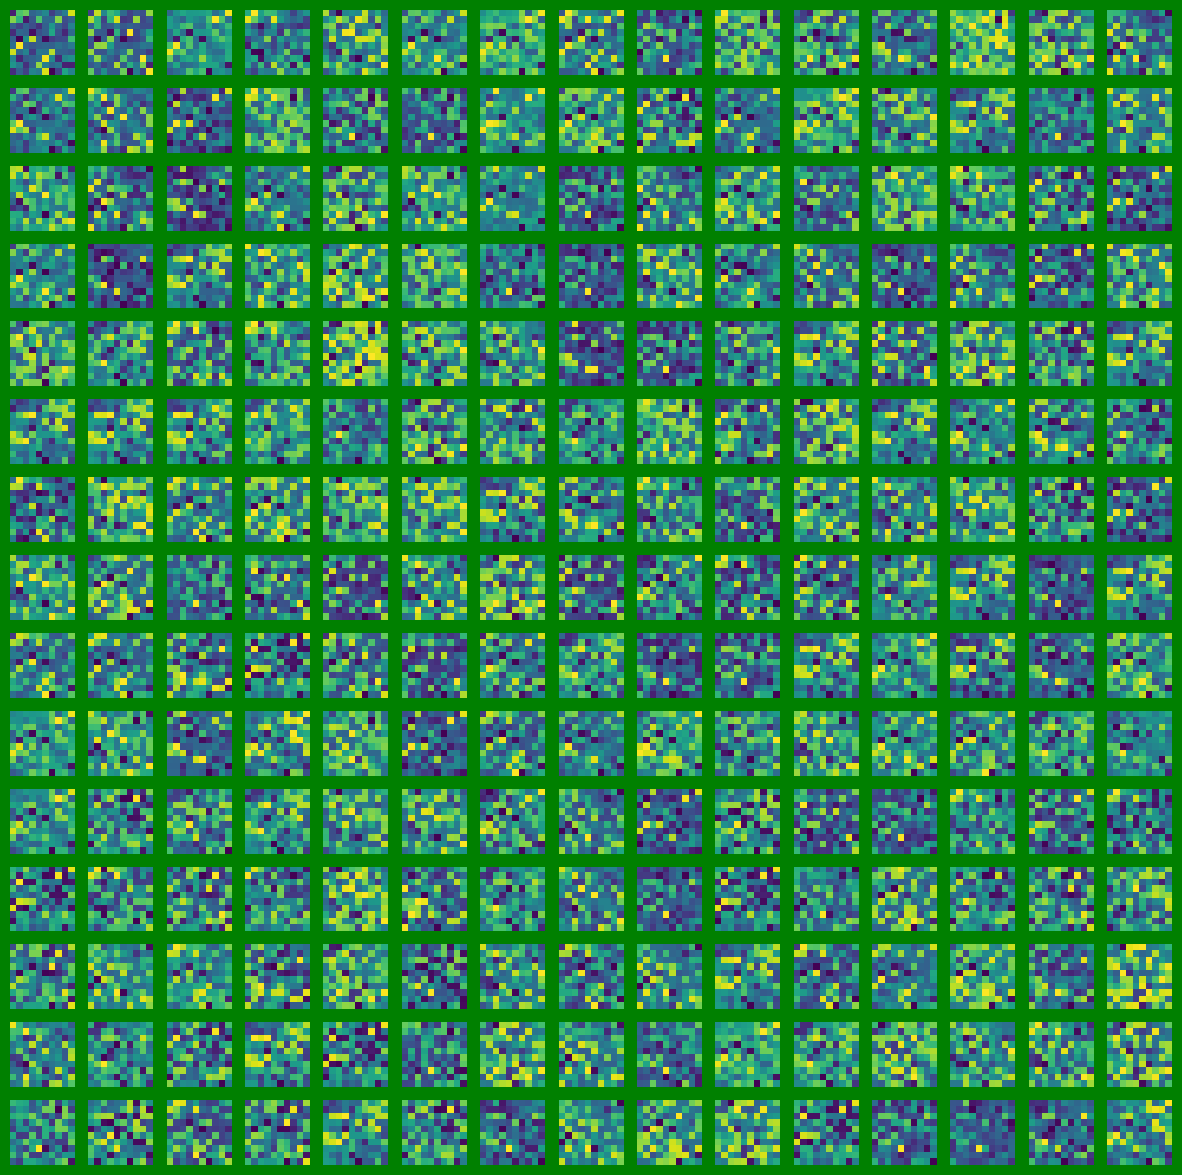

In [280]:
plot_map(FMs[1].reshape(int(FMs[1].shape[0]**0.5), int(FMs[1].shape[0]**0.5), *FMs[1].shape[1:]).detach().numpy())

## CI 1

Sequential(
  (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
  (1): triangle_cReLU(w = 8.818740844726562, percent=0.5)
  (2): SFM(
    filter=(2, 2), alpha=[[0.9  0.93]
     [0.96 0.99]]
  )
  (3): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
  )
)
(5, 5) (4, 4) tensor([2, 2])
segments shape: torch.Size([45000, 10, 10, 1])


C:\Users\user\AppData\Local\Temp\ipykernel_26520\909383208.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


output shape: torch.Size([45000, 225])
CI shape: torch.Size([225, 1, 10, 10, 1])


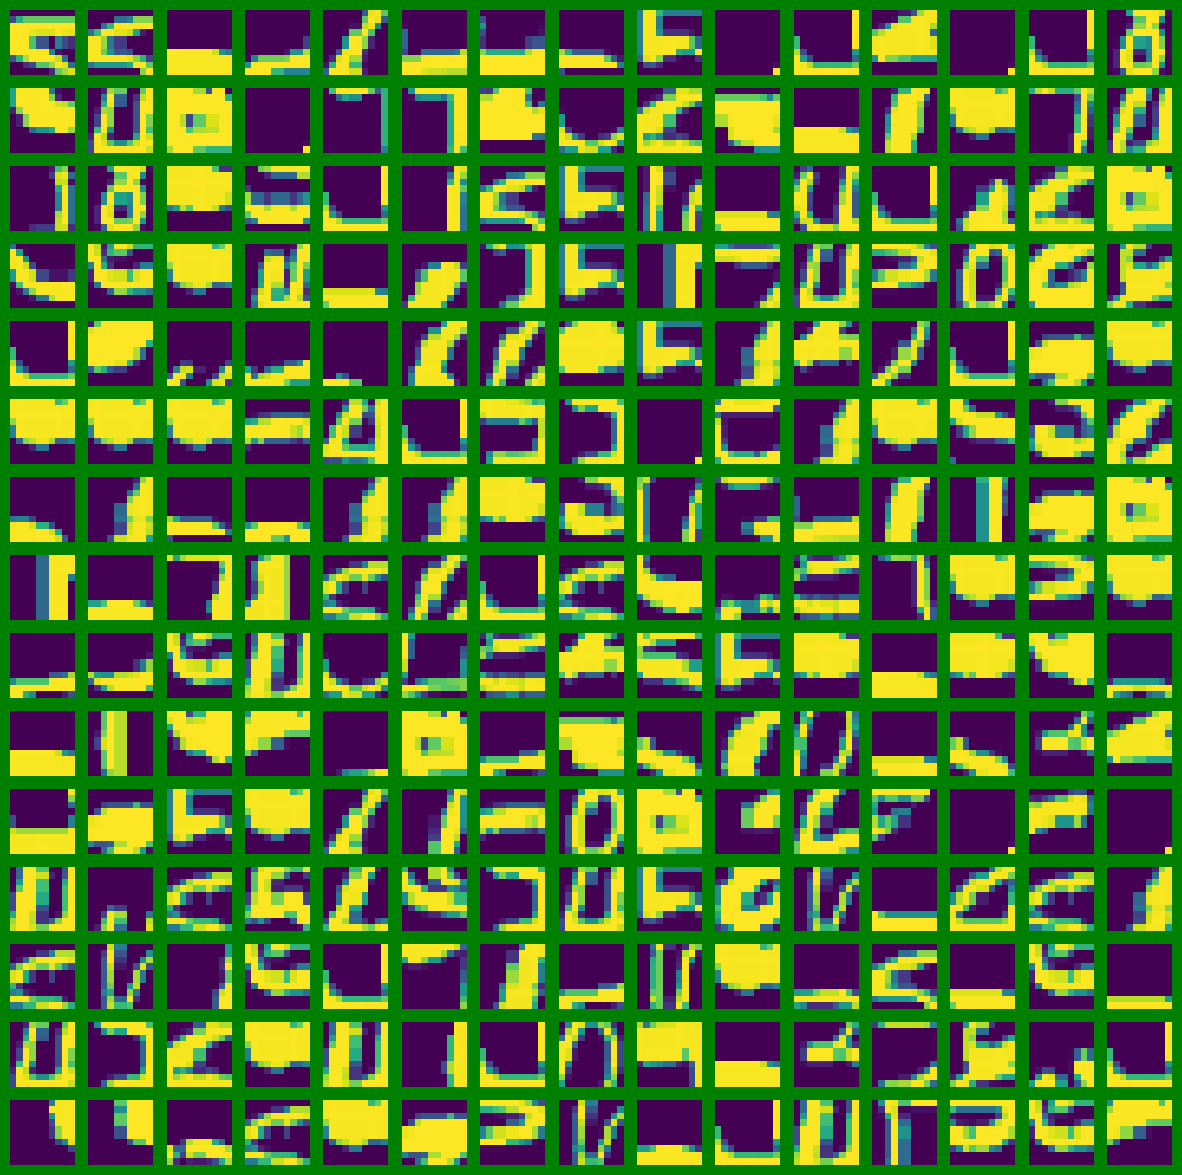

In [281]:
layer = nn.Sequential(*(list(model.convs[0]) + list([model.convs[1][:1]])))
print(layer)

kernel_size=arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 
sfm_filter = torch.prod(torch.tensor(arch['args']['SFM_filters'][:1]), dim=0)
print(kernel_size, stride, sfm_filter)

CI, CI_idx, CI_values = get_ci(images, layer, kernel_size=kernel_size, stride=stride, sfm_filter=sfm_filter)
CIs[1] = CI
layers[1] = layer
CI = CI.reshape((int(CI.shape[0]**0.5), int(CI.shape[0]**0.5), *CI.shape[2:]))
plot_map(CI)

# Layer 2

## FM 2

In [282]:
FMs[2] = model.convs[2][0].weight.reshape(-1, int(model.convs[2][0].weight.shape[1]**0.5), int(model.convs[2][0].weight.shape[1]**0.5), 1)
print(f"FMs[2] = {FMs[2].shape}")

FMs[2] = torch.Size([625, 15, 15, 1])


## CI 2

Sequential(
  (0): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
    (1): triangle_cReLU(w = 8.818740844726562, percent=0.5)
    (2): SFM(
      filter=(2, 2), alpha=[[0.9  0.93]
       [0.96 0.99]]
    )
  )
  (1): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
    (1): triangle_cReLU(w = 9.15491771697998, percent=0.4000000059604645)
    (2): SFM(filter=(1, 3), alpha=[[0.9   0.945 0.99 ]])
  )
  (2): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
)
(5, 5) (4, 4) tensor([2, 6])
segments shape: torch.Size([15000, 10, 30, 1])


C:\Users\user\AppData\Local\Temp\ipykernel_26520\909383208.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


output shape: torch.Size([15000, 625])
CI shape: torch.Size([625, 1, 10, 30, 1])


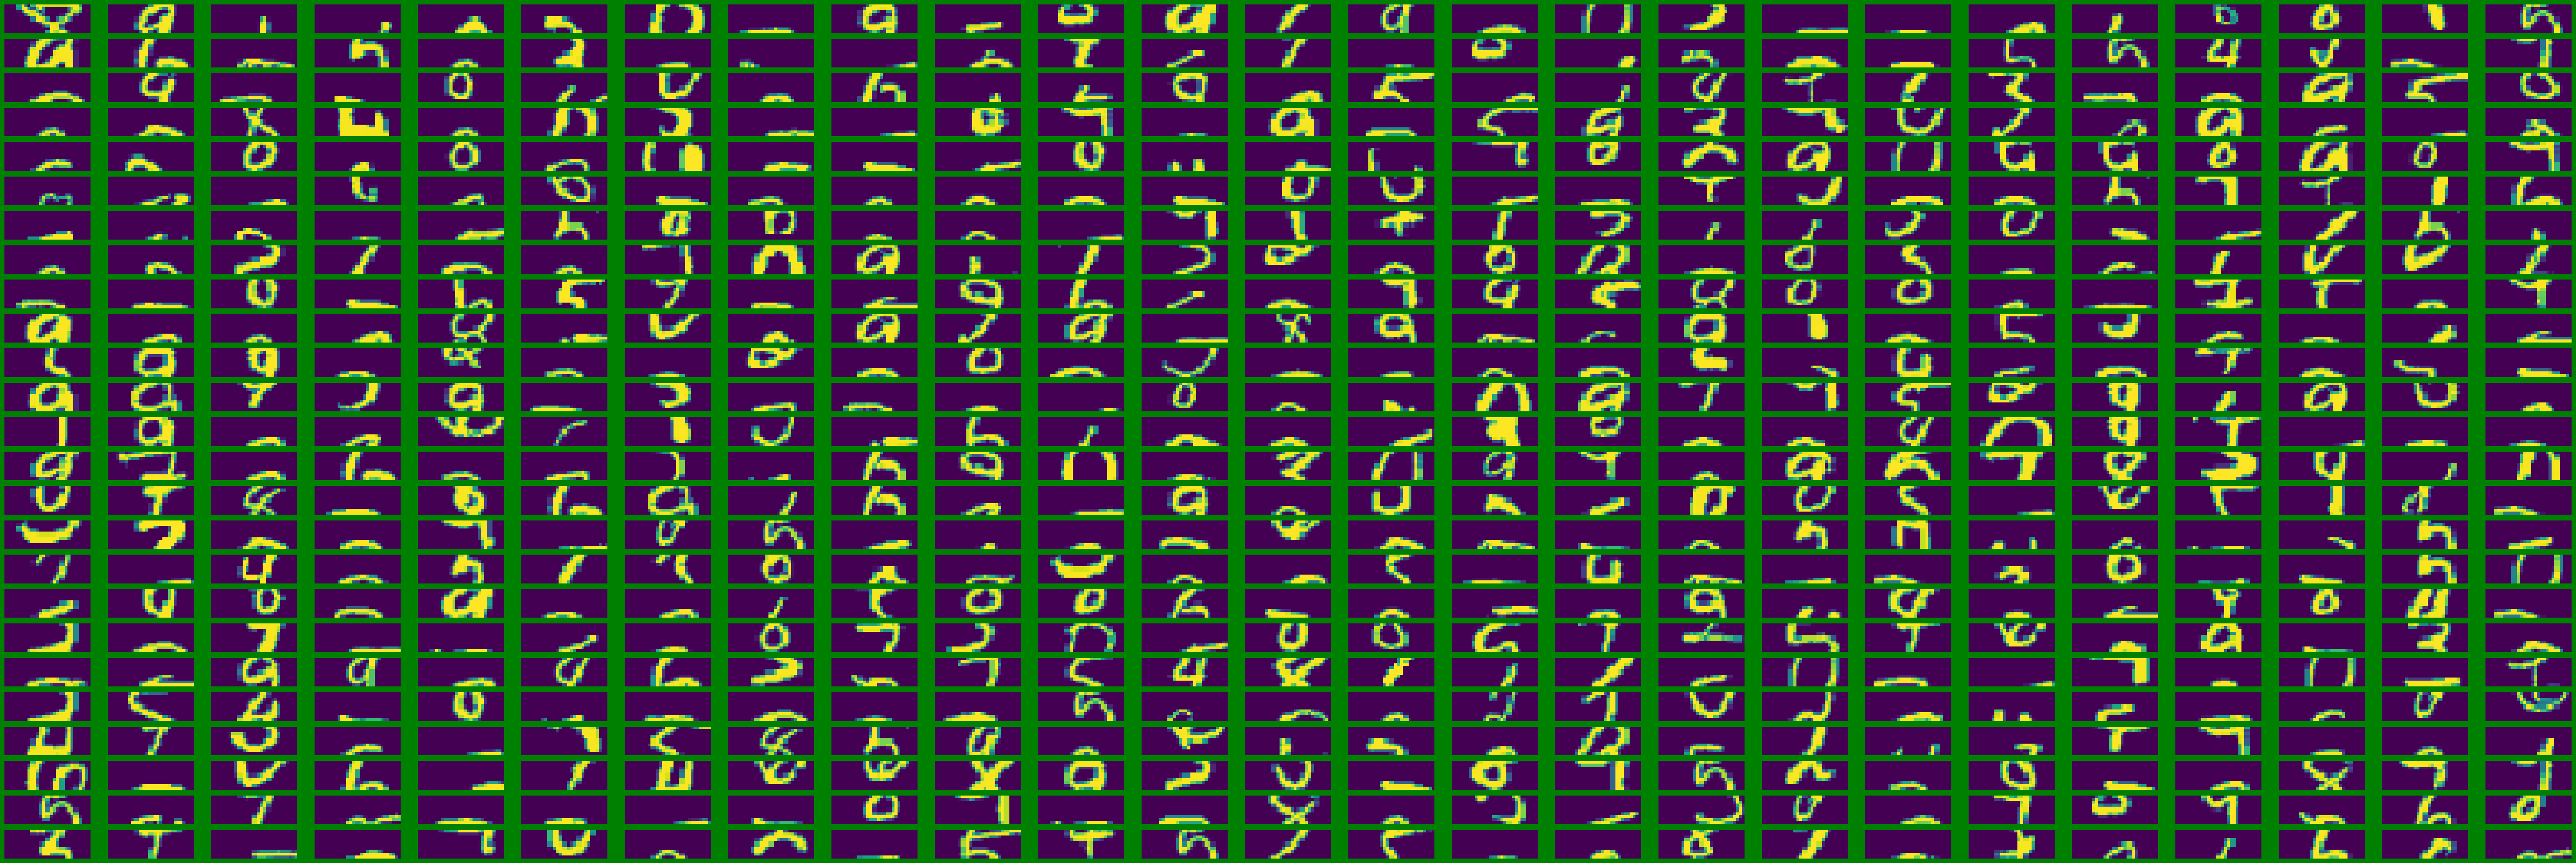

In [283]:
layer = nn.Sequential(*(list(model.convs[:2]) + list([model.convs[2][0]])))
print(layer)

kernel_size=arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 
sfm_filter = torch.prod(torch.tensor(arch['args']['SFM_filters'][:2]), dim=0)
print(kernel_size, stride, sfm_filter)

CI, CI_idx, CI_values = get_ci(images, layer, kernel_size=kernel_size, stride=stride, sfm_filter=sfm_filter)
CIs[2] = CI
layers[2] = layer
CI = CI.reshape((int(CI.shape[0]**0.5), int(CI.shape[0]**0.5), *CI.shape[2:]))
plot_map(CI)

# Layer 3

## FM 3

In [284]:
FMs[3] = model.convs[3][0].weight.reshape(-1, int(model.convs[3][0].weight.shape[1]**0.5), int(model.convs[3][0].weight.shape[1]**0.5), 1)
print(f"FMs[3] = {FMs[3].shape}")

FMs[3] = torch.Size([1225, 25, 25, 1])


## CI 3

Sequential(
  (0): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
    (1): triangle_cReLU(w = 8.818740844726562, percent=0.5)
    (2): SFM(
      filter=(2, 2), alpha=[[0.9  0.93]
       [0.96 0.99]]
    )
  )
  (1): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
    (1): triangle_cReLU(w = 9.15491771697998, percent=0.4000000059604645)
    (2): SFM(filter=(1, 3), alpha=[[0.9   0.945 0.99 ]])
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
    (1): triangle_cReLU(w = 17.383779525756836, percent=0.30000001192092896)
    (2): SFM(
      filter=(3, 1), alpha=[[0.9  ]
       [0.945]
       [0.99 ]]
    )
  )
  (3): RBF_Conv2d(initial = kaiming, weight shape = (1225, 625, 1, 1))
)
(5, 5) (4, 4) tensor([6, 6])
segments shape: torch.Size([5000, 30, 30, 1])


C:\Users\user\AppData\Local\Temp\ipykernel_26520\909383208.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


output shape: torch.Size([5000, 1225])
CI shape: torch.Size([1225, 1, 30, 30, 1])


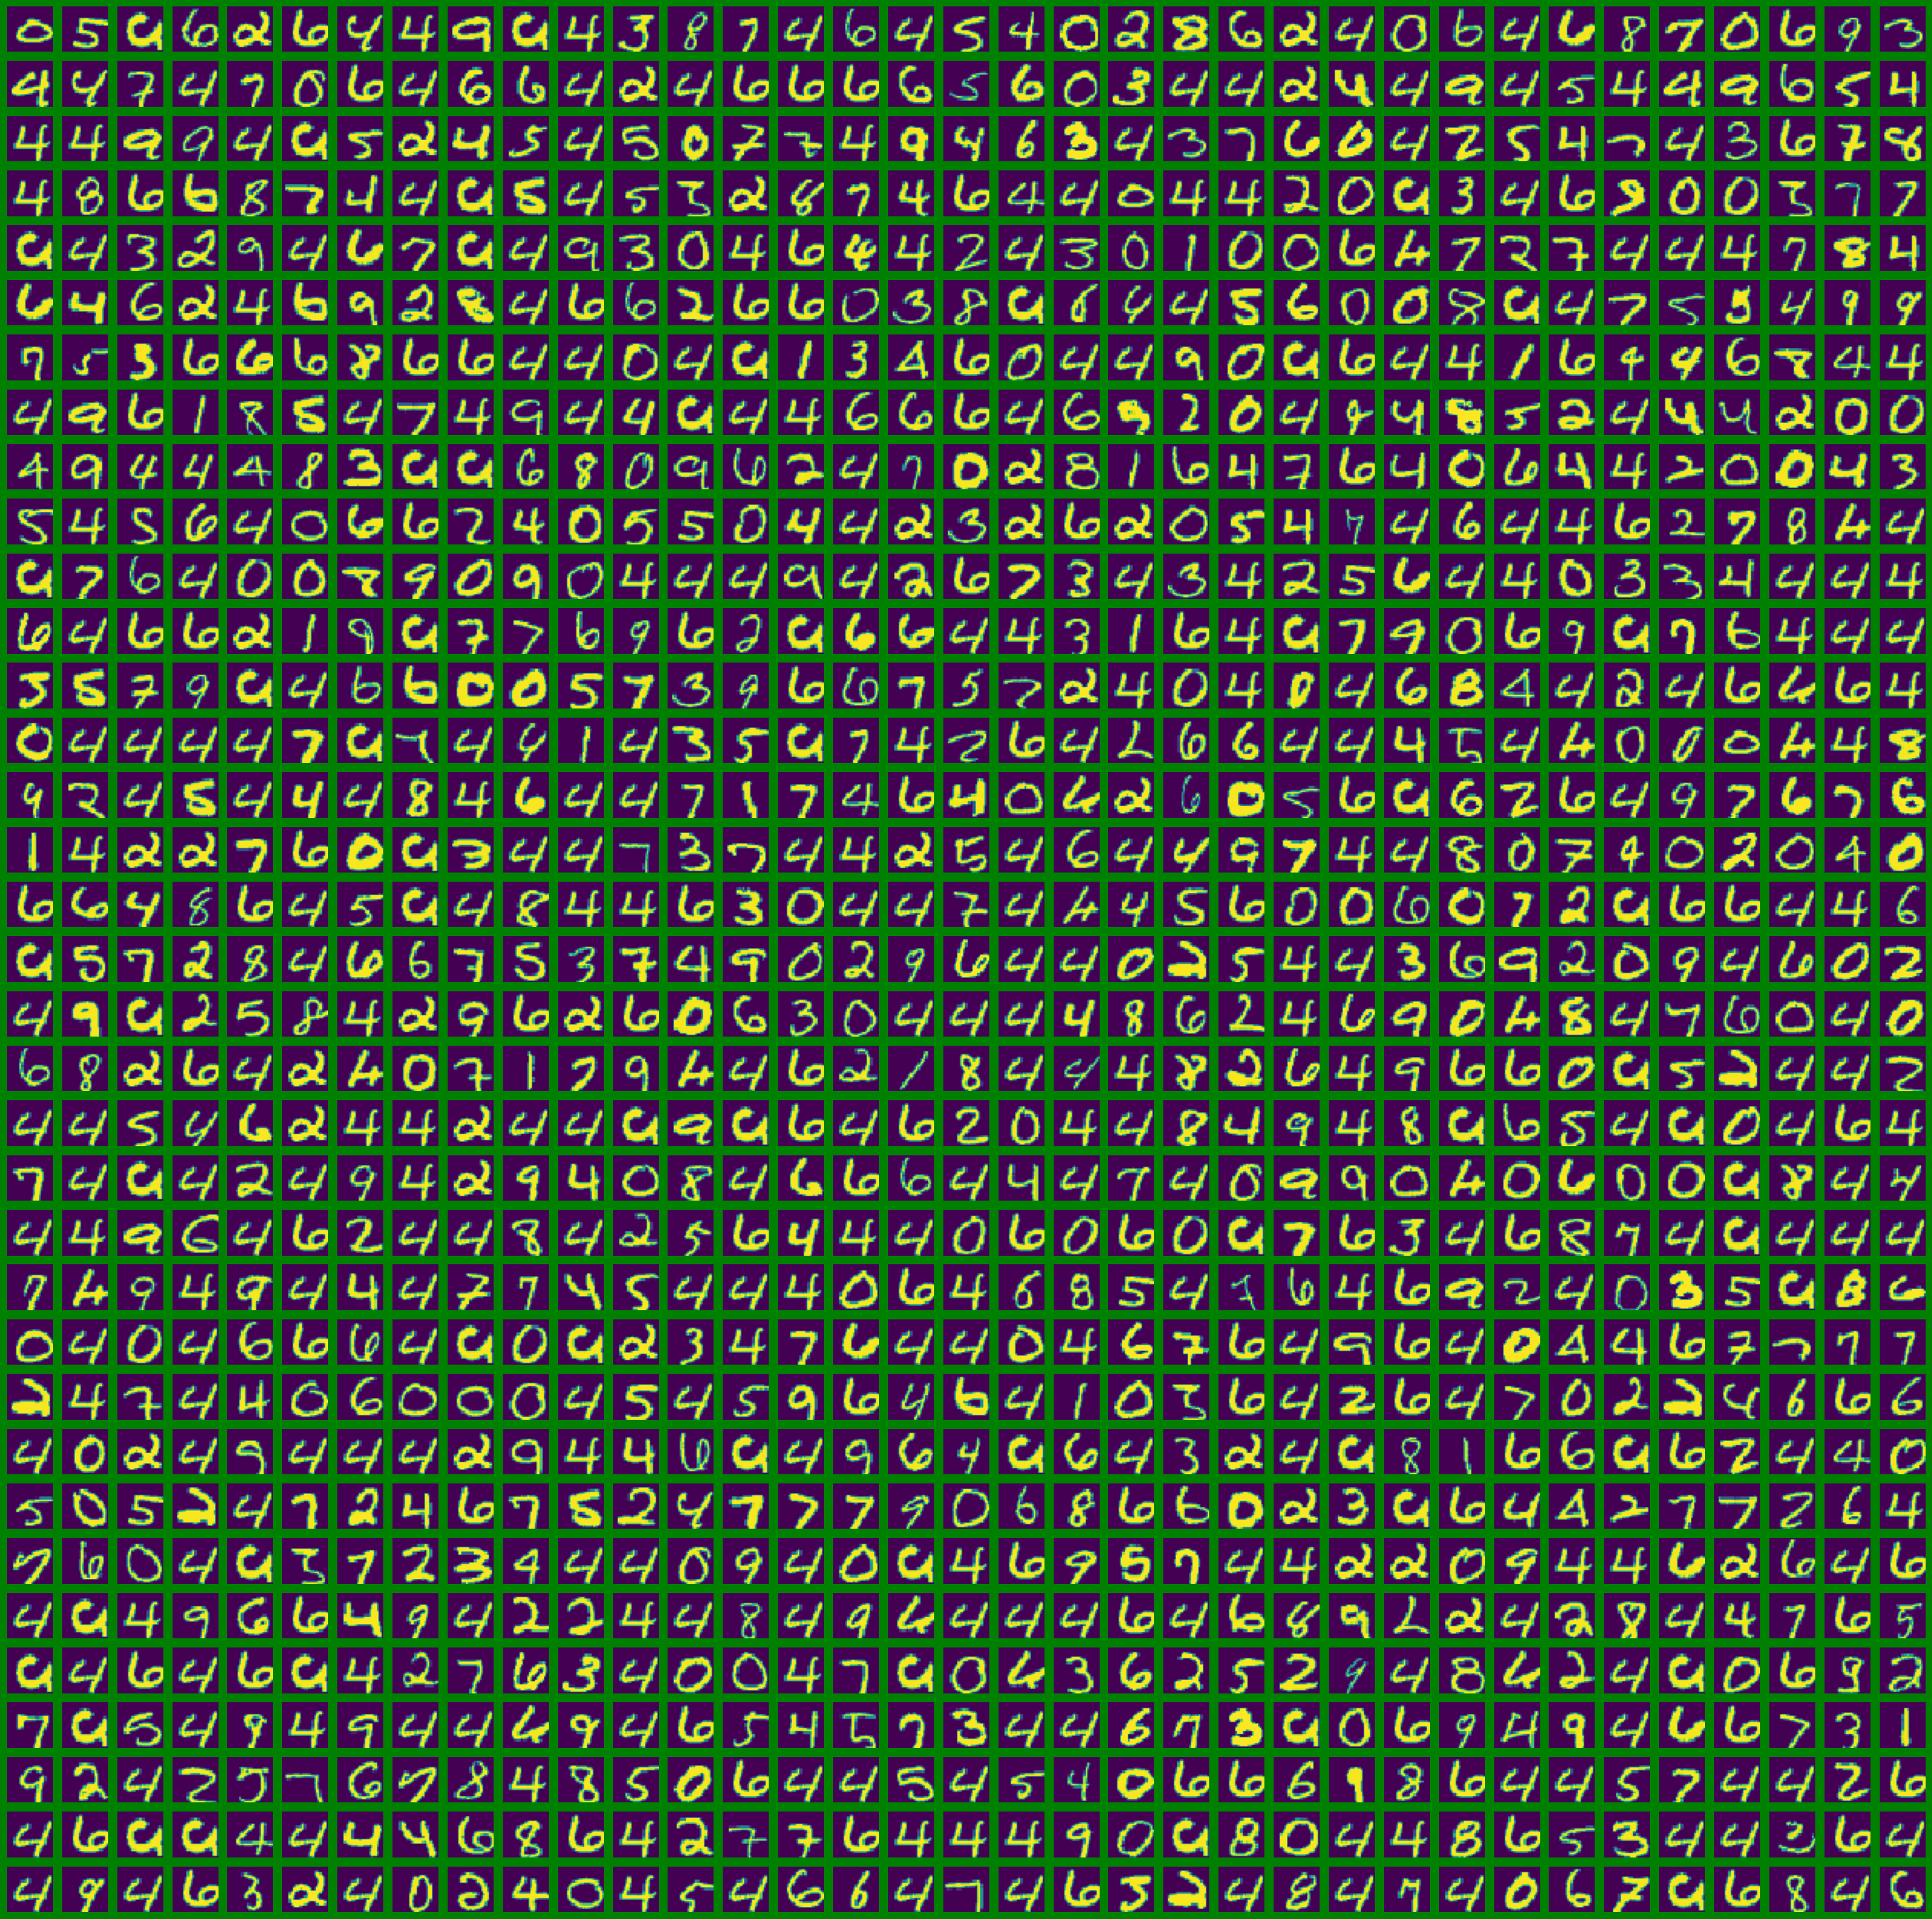

In [285]:
layer = nn.Sequential(*(list(model.convs[:3]) + list([model.convs[3][0]])))
print(layer)

kernel_size=arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 
sfm_filter = torch.prod(torch.tensor(arch['args']['SFM_filters'][:3]), dim=0)
print(kernel_size, stride, sfm_filter)

CI, CI_idx, CI_values = get_ci(images, layer, kernel_size=kernel_size, stride=stride, sfm_filter=sfm_filter)
CIs[3] = CI
layers[3] = layer
CI = CI.reshape((int(CI.shape[0]**0.5), int(CI.shape[0]**0.5), *CI.shape[2:]))
plot_map(CI)

# RM、RM_CI

2767
tensor(3)
tensor(3)


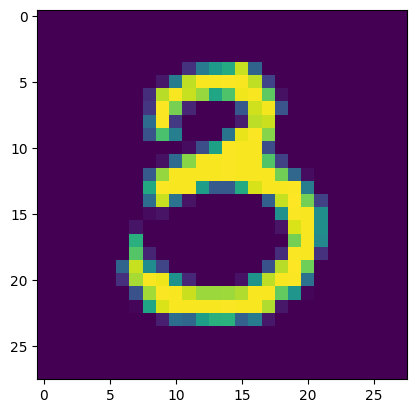

In [325]:
import random
test_id = random.randint(0, len(images))

print(test_id)
test_img = images[test_id]

pred = model(test_img.unsqueeze(0))
print(labels[test_id].argmax())
print(pred.argmax())

plt.imshow(test_img.permute(1,2,0))
plt.show()

## Layer 0

torch.Size([100, 6, 6])


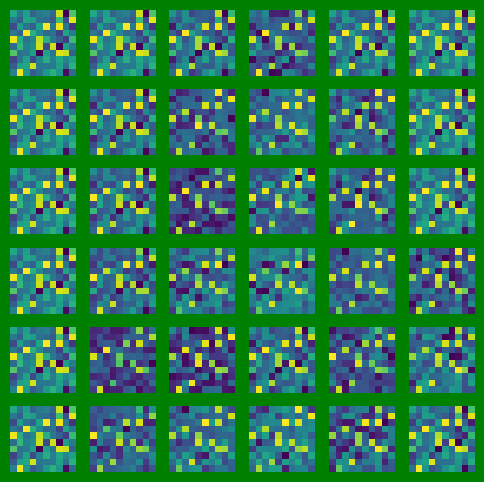

torch.Size([100, 1, 5, 5, 1])


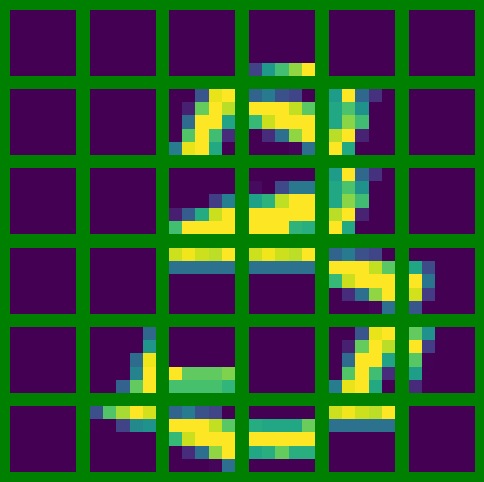

In [326]:
layer_num = 0
RM = layers[layer_num](test_img.unsqueeze(0))[0]
print(RM.shape)
RM_H, RM_W = RM.shape[1], RM.shape[2]
plot_map(RM.permute(1,2,0).reshape(RM_H,RM_W,int(RM.shape[0] ** 0.5),int(RM.shape[0] ** 0.5),1))

print(CIs[layer_num].shape)
CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=False).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,1)
plot_map(RM_CI)

## Layer 1

torch.Size([225, 3, 3])


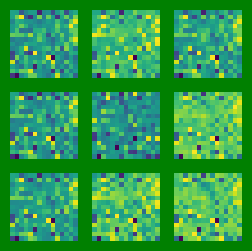

torch.Size([225, 1, 10, 10, 1])
tensor([[[2.6985, 1.8257, 2.4399],
         [2.6909, 2.5869, 1.8757],
         [2.2494, 1.8787, 1.5994]]])


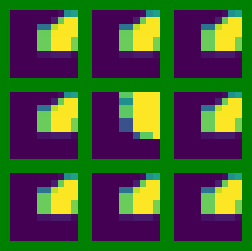

In [327]:
layer_num = 1
RM = layers[layer_num](test_img.unsqueeze(0))[0]
print(RM.shape)
RM_H, RM_W = RM.shape[1], RM.shape[2]
plot_map(RM.permute(1,2,0).reshape(RM_H,RM_W,int(RM.shape[0] ** 0.5),int(RM.shape[0] ** 0.5),1))

print(CIs[layer_num].shape)
CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
print(torch.topk(RM, k=1, dim=0, largest=False).values)
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=False).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,1)
plot_map(RM_CI)

## Layer 2

torch.Size([625, 3, 1])


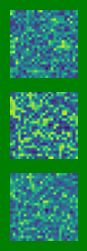

torch.Size([625, 1, 10, 30, 1])


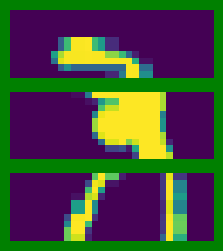

In [328]:
layer_num = 2
RM = layers[layer_num](test_img.unsqueeze(0))[0]
print(RM.shape)
RM_H, RM_W = RM.shape[1], RM.shape[2]
plot_map(RM.permute(1,2,0).reshape(RM_H,RM_W,int(RM.shape[0] ** 0.5),int(RM.shape[0] ** 0.5),1))

print(CIs[layer_num].shape)
CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=False).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,1)
plot_map(RM_CI)

## Layer 3

In [336]:
print(layers[layer_num])

Sequential(
  (0): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
    (1): triangle_cReLU(w = 8.818740844726562, percent=0.5)
    (2): SFM(
      filter=(2, 2), alpha=[[0.9  0.93]
       [0.96 0.99]]
    )
  )
  (1): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
    (1): triangle_cReLU(w = 9.15491771697998, percent=0.4000000059604645)
    (2): SFM(filter=(1, 3), alpha=[[0.9   0.945 0.99 ]])
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
    (1): triangle_cReLU(w = 17.383779525756836, percent=0.30000001192092896)
    (2): SFM(
      filter=(3, 1), alpha=[[0.9  ]
       [0.945]
       [0.99 ]]
    )
  )
  (3): RBF_Conv2d(initial = kaiming, weight shape = (1225, 625, 1, 1))
)


torch.Size([1225, 1, 1])


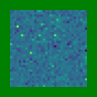

torch.Size([1225, 1, 30, 30, 1])


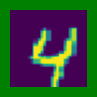

In [335]:
layer_num = 3
RM = layers[layer_num](test_img.unsqueeze(0))[0]
print(RM.shape)
RM_H, RM_W = RM.shape[1], RM.shape[2]
plot_map(RM.permute(1,2,0).reshape(RM_H,RM_W,int(RM.shape[0] ** 0.5),int(RM.shape[0] ** 0.5),1))

print(CIs[layer_num].shape)
CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=False).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,1)
plot_map(RM_CI)

# Lab


In [330]:
# i = 1

# plot = torch.empty(15, 15*2, 1)
# plot[:, :15] = FMs[0][i]
# plot[:, 15:] = CIs[0][i][0]
# plt.imshow(plot, cmap='gray',vmax=1 ,vmin=0)
# plt.show()

# # FM
# plt.imshow(FMs[0][i], cmap='gray')
# plt.colorbar()
# plt.show()
# # CI, CI_idx, CI_values
# plt.imshow(CIs[0][i][0], cmap='gray',vmax=1 ,vmin=0)
# plt.colorbar()
# plt.show()


# images_idx = int(CI_idx[i][0] // 16)
# segment_idx = int(CI_idx[i][0] % 16)
# print(f"images_idx = {images_idx}, segment_idx = {segment_idx}")
# print(f"")

# kernel_size = arch['args']['Conv2d_kernel'][0]
# stride = (arch['args']['strides'][0], arch['args']['strides'][0])

# segments = split(images[images_idx].unsqueeze(0), kernel_size=kernel_size, stride=stride)
# print(f"segments.shape = {segments.shape}")
# plot_map(segments[0].permute(1,2,3,4,0), cmap='gray', vmax=1, vmin=0)


In [331]:
# print(CI_values[i])
# print(FMs[0][i].shape)

In [332]:
# print(segments.shape)

# for idx_i in range(4):
#     for idx_j in range(4):
#         pow_sum = 0
#         for i in range(15):
#             for j in range(15):
#                 pow_sum += (segments[0][0][idx_i][idx_j][i][j] - FMs[0][1][i][j][0])**2
#         print(pow_sum ** 0.5)
#     print()

In [333]:
# segments_flatten = segments.reshape(16,-1)

# dist_arr = torch.cdist(FMs[0][i].reshape(1,-1),segments_flatten)
# # dist_arr = 1 - dist_arr / arch['args']['w_arr'][0]
# dist_arr = dist_arr.reshape(4,4)

# plt.imshow(dist_arr)
# plt.colorbar()
# for i in range(dist_arr.shape[0]):
#     for j in range(dist_arr.shape[1]):
#         text = plt.text(j, i, '{:.3f}'.format(dist_arr[i, j]), ha="center", va="center")
# plt.show()